# Import packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import gridspec
import matplotlib

In [2]:
dataarray_SST_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_piControl_interp_2x2_15memens_3.nc')
dataarray_SST_cont.load()

dataarray_Qo_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_ocean_piControl_2x2_15memens_2.nc')
dataarray_Qo_cont.load()

dataarray_Qs_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_piControl_2x2_15memens_2.nc')
dataarray_Qs_cont.load()

mlotst = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_2x2_15memens.nc')
mlotst.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [50.41090584, 52.04710674, 50.50968361, ..., 48.75899982,
          49.236413  , 46.89223766],
         [31.22230101, 32.50833845, 32.35529757, ..., 40.54614592,
          40.76375866, 39.32892752],
         [53.78388977, 52.79047012, 53.00532818, ..., 47.45863438,
          47.6057272 , 50.86550903]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [22.22373772, 19.68608475, 17.70999527, ..., 32.2755928 ,
          30.69525719, 27.84095955],
         [25.45349121, 25.06351852, 24.72636795, ..., 25.39812469,
          25.5584774 , 25.59752464],
         [24.32390594, 24.3410244 , 24.33765221, ..., 23.76138496,
          24.04454803, 24.23335075]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [31.01957703, 27.70540428, 25.07566071, ..., 39.35926056,
          38.68805313, 36.53044891],
         [35.33967209, 34.22472763, 33.02606201, ..., 34.47336197,
          35.42287064, 35.58819199],
         [32.27497101, 32.29590225, 32.31086731, ..., 31.77479553,
          32.05541229, 32.22546387]]]])
Coordinates:
    latitude   (lat, lon) float32 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float32 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'HadGEM3-GC31-LL'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [3]:
Qo_mean = dataarray_Qo_cont.mean('time').mean('name')
Qs_mean = dataarray_Qs_cont.mean('time').mean('name')

In [4]:
def lagregress(Q, SST, lagint):
    
    lag_series = np.arange(-lagint, lagint, 1)
    lagresponse_q = np.zeros(len(lag_series))
    
    i = 0
    for lag in lag_series:
        if lag < 0:
            lagged_Q = Q.shift(time=-lag).isel(time=slice(-lag,1500))
            lagged_sst = SST.isel(time=slice(-lag,1500))
        elif lag == 0:
            lagged_Q = Q
            lagged_sst = SST.isel(time=slice(0,1500))
        elif lag > 0:
            lagged_Q = Q.shift(time=-lag).isel(time=slice(0,1500-lag))
            lagged_sst = SST.isel(time=slice(0,1500-lag))
        # Remove seasonality
        climatology_sst = lagged_sst.groupby('time.month').mean('time')
        sst_anomalies = lagged_sst.groupby('time.month') - climatology_sst
        climatology_rad = lagged_Q.groupby('time.month').mean('time')
        rad_anomalies = lagged_Q.groupby('time.month') - climatology_rad
        lagresponse_q[i] = np.polyfit(sst_anomalies, rad_anomalies, deg=1)[0]
        i += 1
        
    return lagresponse_q, lag_series

In [5]:
# Analytical solution

def analytical(params, lagint):
    lambda_o = params['lambda_o'] # Ocean feedback
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    dt = 60*60*24*30 # Timestep - month [s]
        
    lag_series = np.arange(-lagint,lagint,1)*dt
        
    c = c_p*density*mlotst_equator # Heat capacity
    
    w_0 = (lambda_a + lambda_o)/c

    eq_secondhalf = (lambda_a + lambda_o) * 2/(sigma_a**2+sigma_o**2) * np.exp(-w_0*abs(lag_series))
    
    for i in range(len(eq_secondhalf)):
        if lag_series[i]>0:
            eq_secondhalf[i] = 0
        else:
            eq_secondhalf[i] = eq_secondhalf[i]
        
    # r_analytical = -np.exp(-lambda_a*abs(lag_series*dt)/c)*lambda_a
    r_atmos = -lambda_a*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_a**2
    r_ocean = -lambda_o*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_o**2

    return r_atmos, r_ocean

# (210, 0) - GFDL-ESM4

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

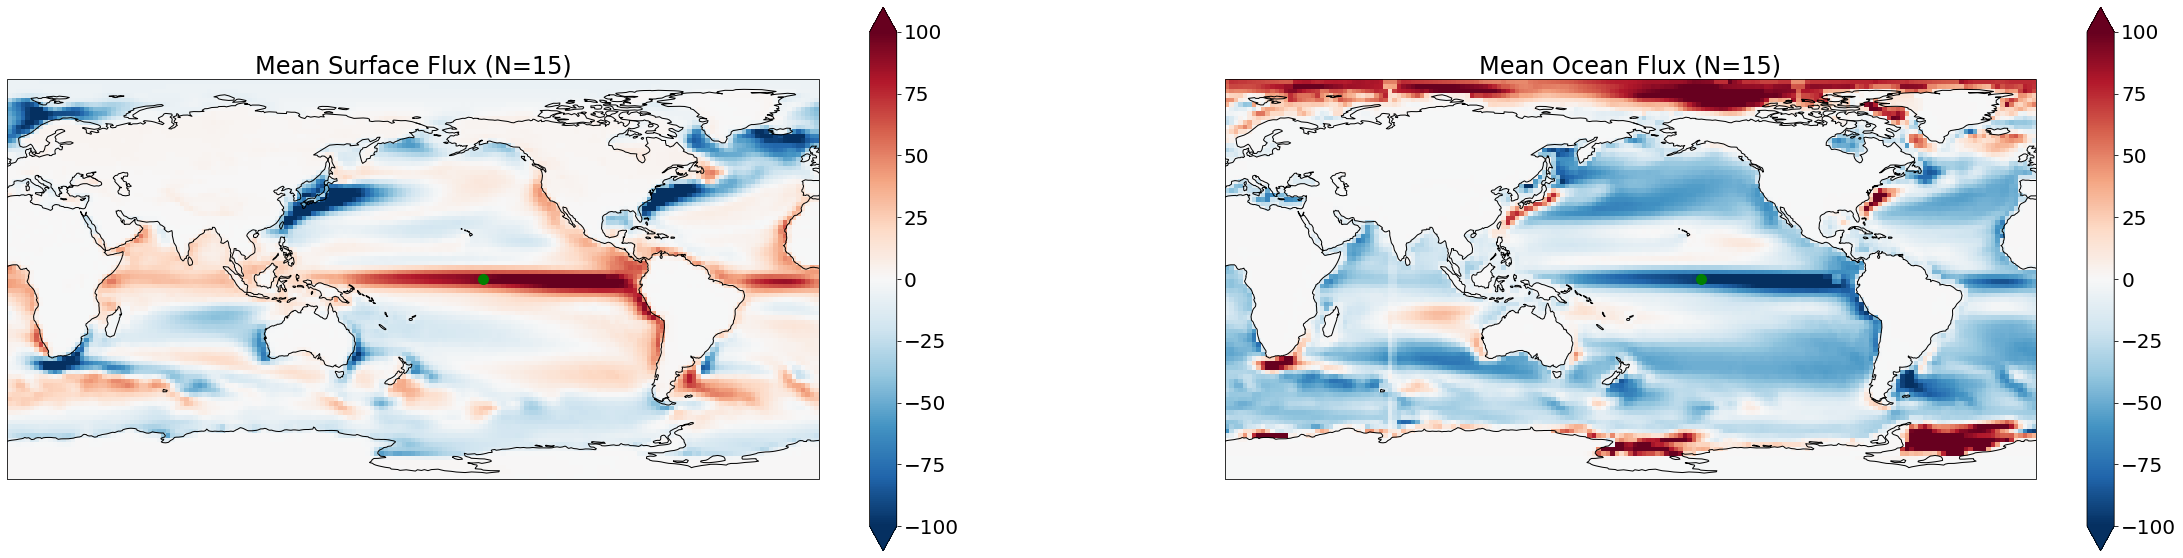

In [111]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 210
lat = 0

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [67]:
atmeq_list = []
oceeq_list = []
i = 0
for model in dataarray_SST_cont['name']:
    atmeq_list.append(lagregress(dataarray_Qs_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name=model),
                              lagint = 12*5))
    oceeq_list.append(lagregress(dataarray_Qo_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name=model),
                         lagint = 12*5))
    i += 1

In [68]:
atmeqlist = []
for i in range(15):
    atmeqlist.append(atmeq_list[i][0])
atmeq = np.mean(atmeqlist, axis=0)

oceeqlist = []
for i in range(15):
    oceeqlist.append(oceeq_list[i][0])
oceeq = np.mean(oceeqlist, axis=0)

In [69]:
params = {}
params['lambda_a'] = 6
params['lambda_o'] = 1
params['sigma_a'] = 1
params['sigma_o'] = 10
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = 22.22147015 # Mixed layer depth at equator - m

analytic_atmos, analytic_ocean = analytical(params, lagint)

Text(0.5, 0.98, '(210,0) - (N=15)')

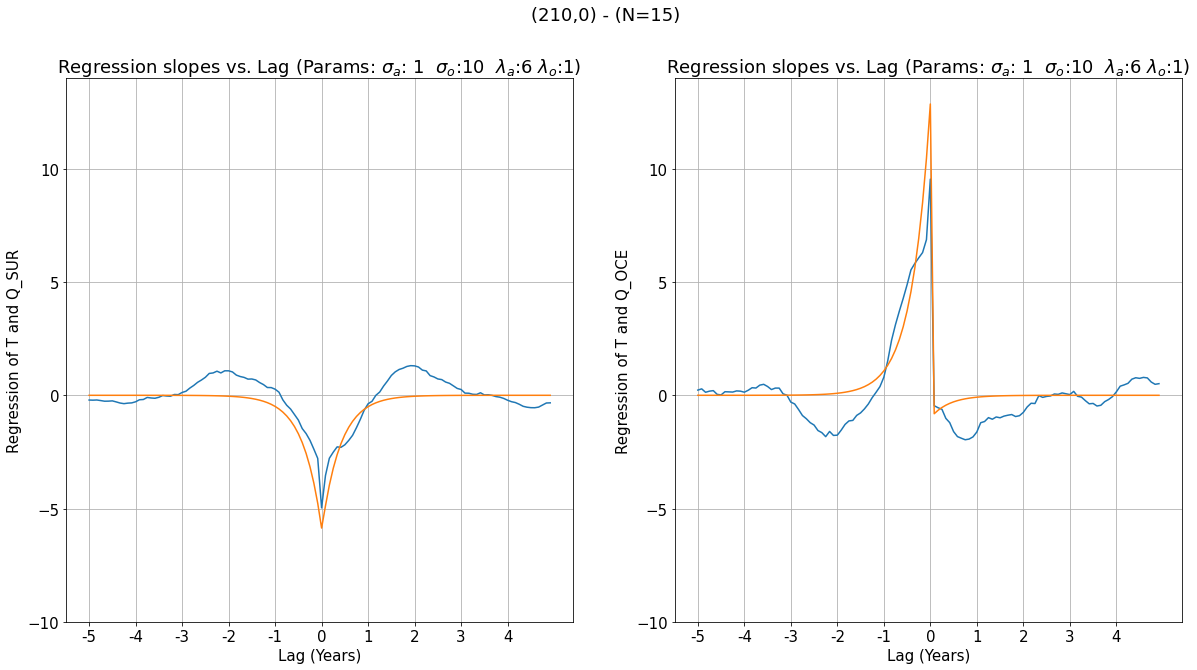

In [70]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax.plot(atmeq_list[0][1], atmeq)
ax.plot(atmeq_list[0][1], analytic_atmos)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-10,14)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(oceeq_list[0][1], oceeq)
ax2.plot(oceeq_list[0][1], analytic_ocean)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_ylim(-10,14)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(210,0) - (N=15)')

Text(0.5, 1.0, 'Mean Ocean Flux - GFDL-ESM4')

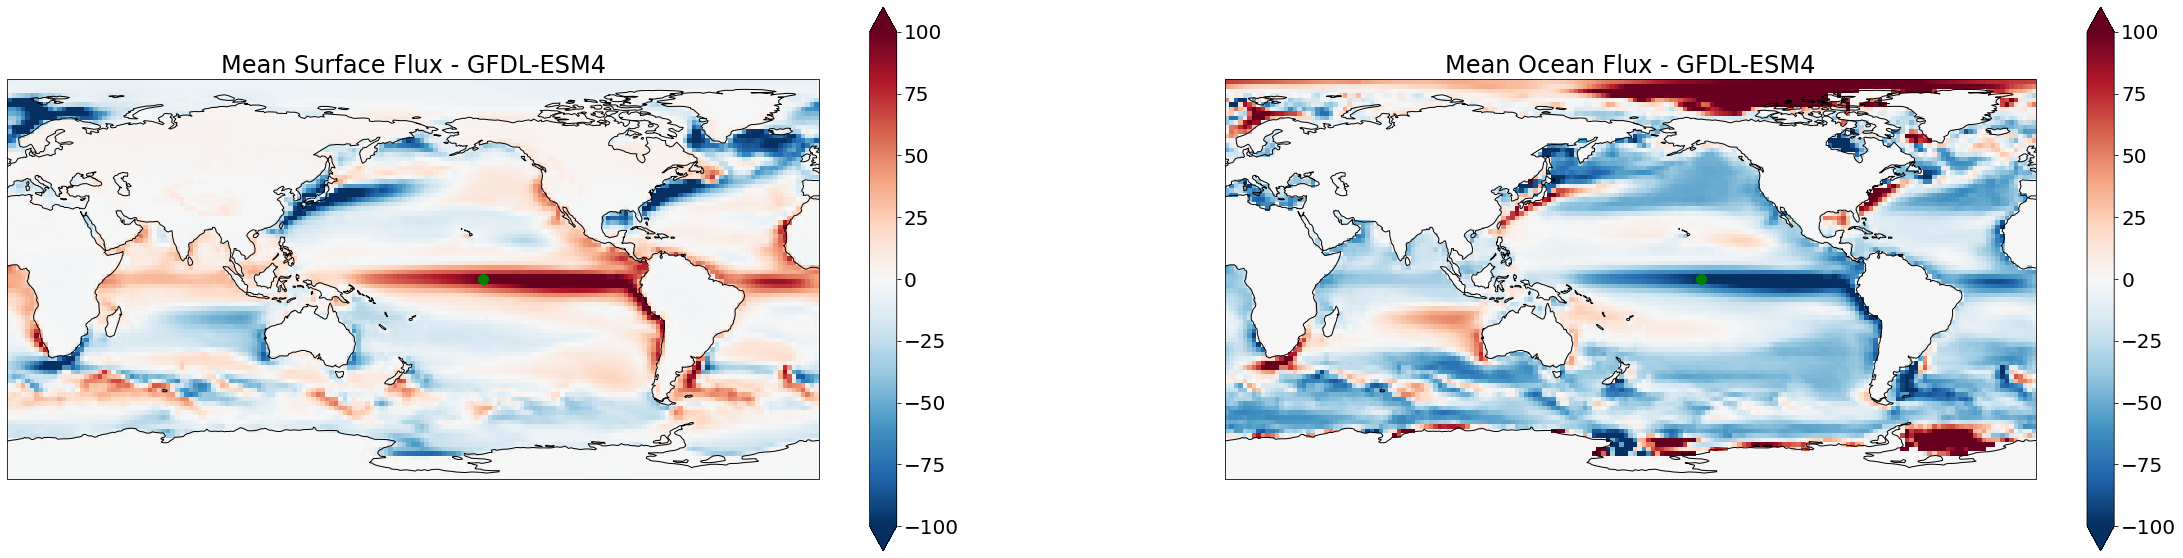

In [110]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 210
lat = 0

Qs_GFDL = dataarray_Qs_cont.sel(name='GFDL-ESM4').mean('time')

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_GFDL.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux - GFDL-ESM4')

Qo_GFDL = dataarray_Qo_cont.sel(name='GFDL-ESM4').mean('time')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_GFDL.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux - GFDL-ESM4')

In [37]:
atmosequator = lagregress(dataarray_Qs_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name='GFDL-ESM4'), 
                         dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name='GFDL-ESM4'),
                         lagint = 12*5)

oceanequator = lagregress(dataarray_Qo_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name='GFDL-ESM4'), 
                         dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name='GFDL-ESM4'),
                         lagint = 12*5)

In [38]:
mean_hml = mlotst.sel(lat=0,method='nearest').sel(lon=210,method='nearest').sel(name='GFDL-ESM4').mean('time')
mean_hml

<xarray.DataArray ()>
array(22.22147015)
Coordinates:
    latitude   float32 1.0
    longitude  float32 -149.0
    lat        int64 1
    lon        int64 211
    name       <U9 'GFDL-ESM4'

In [78]:
params = {}
params['lambda_a'] = 6
params['lambda_o'] = 1
params['sigma_a'] = 1
params['sigma_o'] = 10
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = 22.22147015 # Mixed layer depth at equator - m

analytic_atmos, analytic_ocean = analytical(params, lagint)

Text(0.5, 0.98, '(210,0) - GFDL-ESM4')

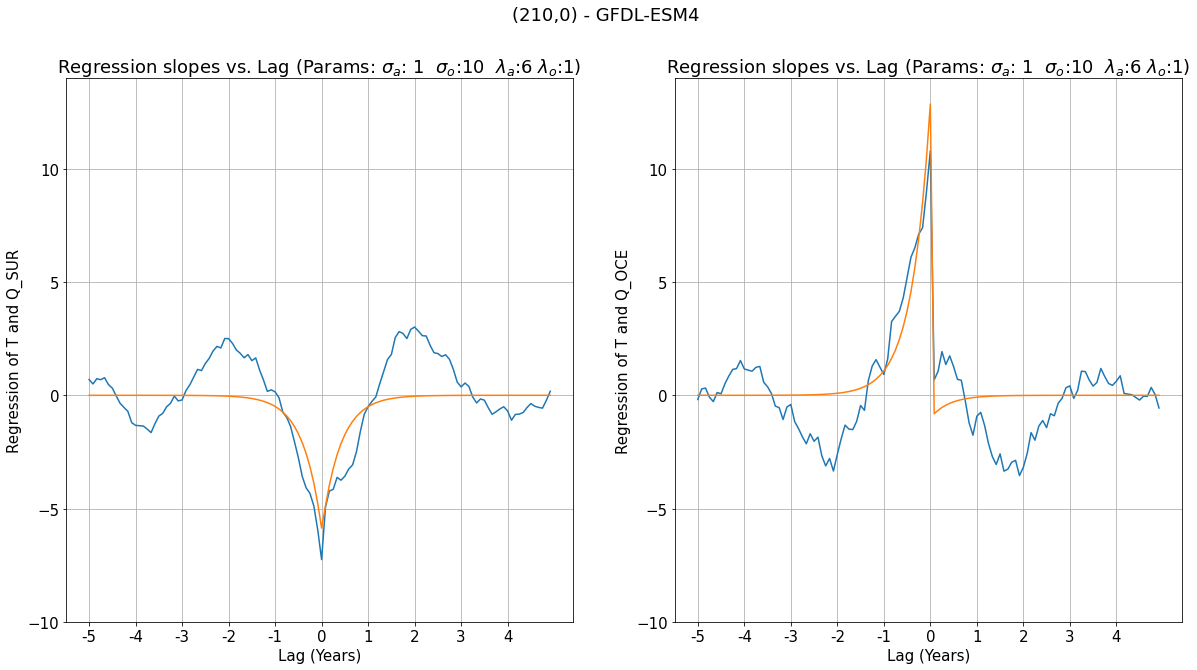

In [87]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax.plot(atmosequator[1], atmosequator[0])
ax.plot(atmosequator[1], analytic_atmos)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-10,14)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(oceanequator[1], oceanequator[0])
ax2.plot(oceanequator[1], analytic_ocean)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_ylim(-10,14)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(210,0) - GFDL-ESM4')

# (145,10) - FGOALS-g3 - Warm Pool

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

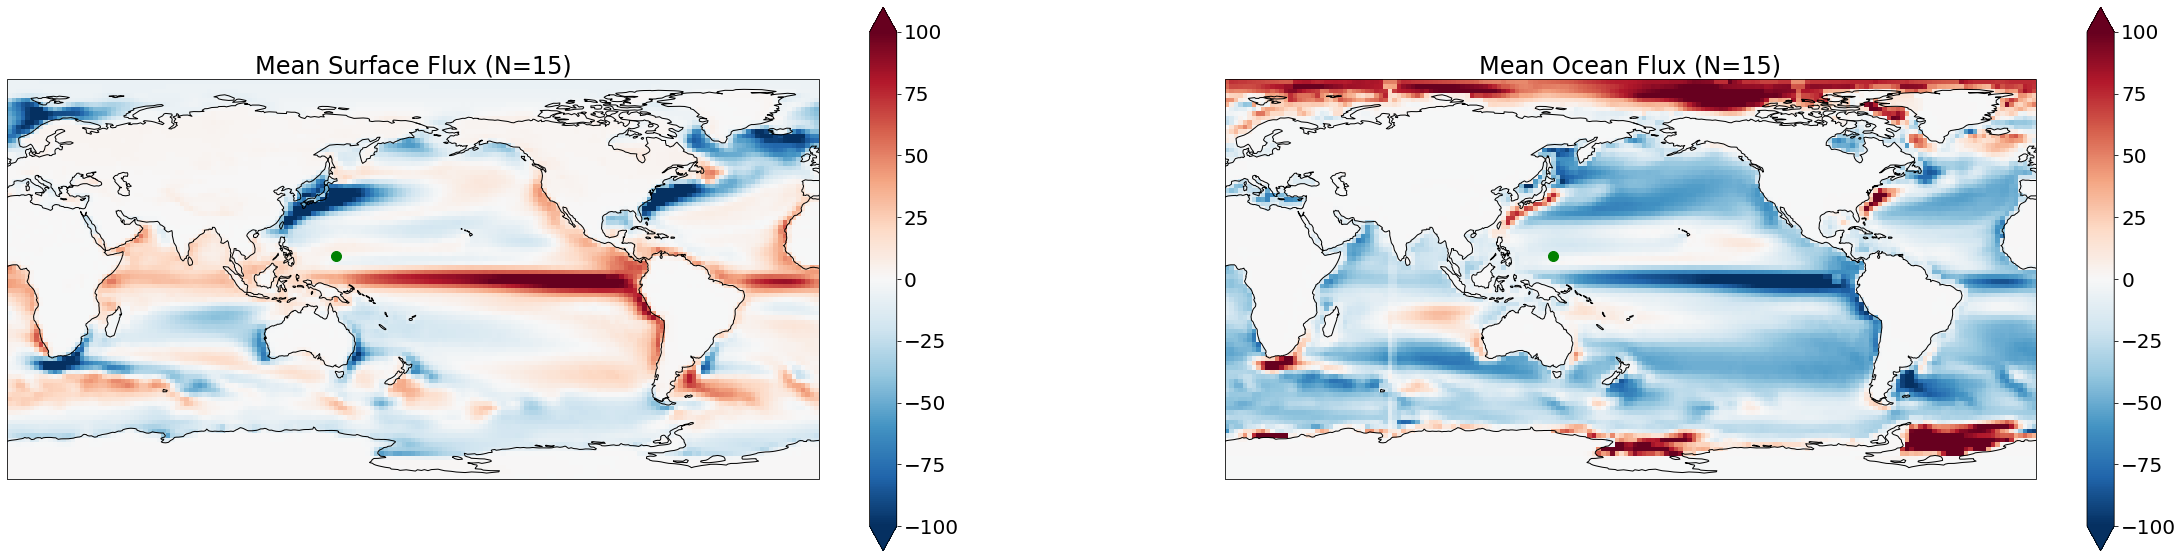

In [70]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 145
lat = 10

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [72]:
atmwp_list = []
ocewp_list = []
for model in dataarray_SST_cont['name']:
    atmwp_list.append(lagregress(dataarray_Qs_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name=model),
                              lagint = 12*5))
    ocewp_list.append(lagregress(dataarray_Qo_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name=model),
                         lagint = 12*5))

In [73]:
atmwplist = []
for i in range(15):
    atmwplist.append(atmwp_list[i][0])
atmwp = np.mean(atmwplist, axis=0)

ocewplist = []
for i in range(15):
    ocewplist.append(ocewp_list[i][0])
ocewp = np.mean(ocewplist, axis=0)

In [74]:
params = {}
params['lambda_a'] = 20
params['lambda_o'] = 20
params['sigma_a'] = 1
params['sigma_o'] = 1
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a month - seconds
mlotst_equator = 53.6764925 # Mixed layer depth at equator - m

atmos_warmpool, ocean_warmpool = analytical(params, lagint)

Text(0.5, 0.98, '(145,10) - (N=15)')

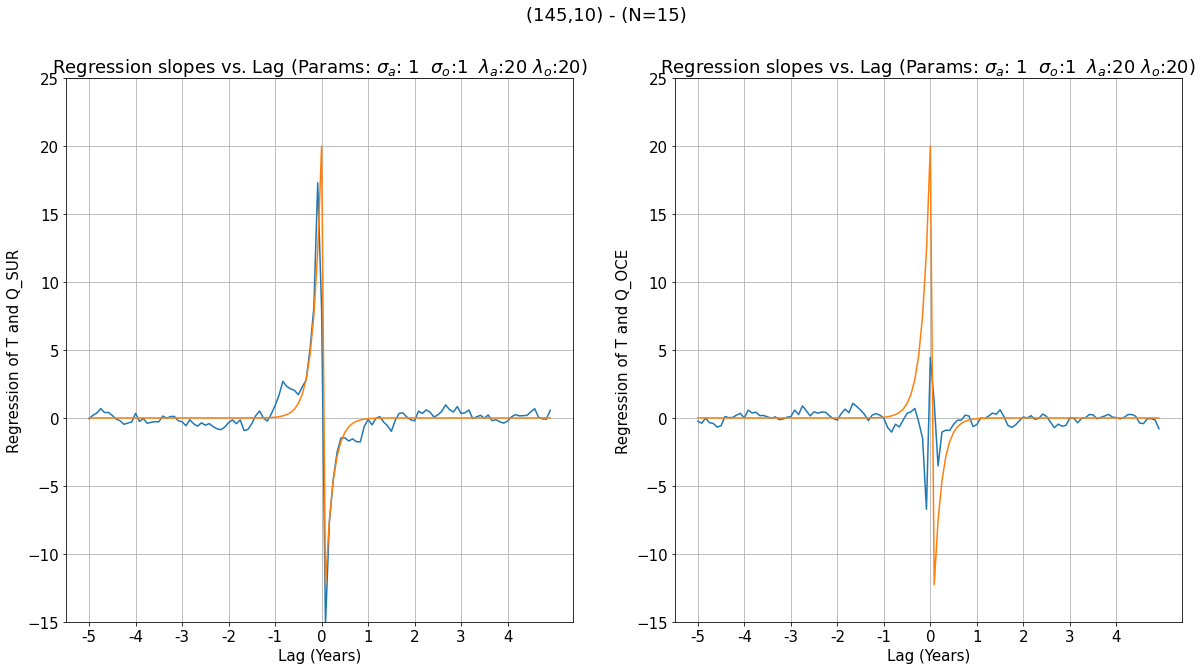

In [75]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax.plot(atmwp_list[0][1], atmwp)
ax.plot(atmwp_list[0][1], atmos_warmpool)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-15,25)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(ocewp_list[0][1], ocewp)
ax2.plot(ocewp_list[0][1], ocean_warmpool)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_ylim(-15,25)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(145,10) - (N=15)')

Text(0.5, 1.0, 'Mean Ocean Flux - FGOALS-g3')

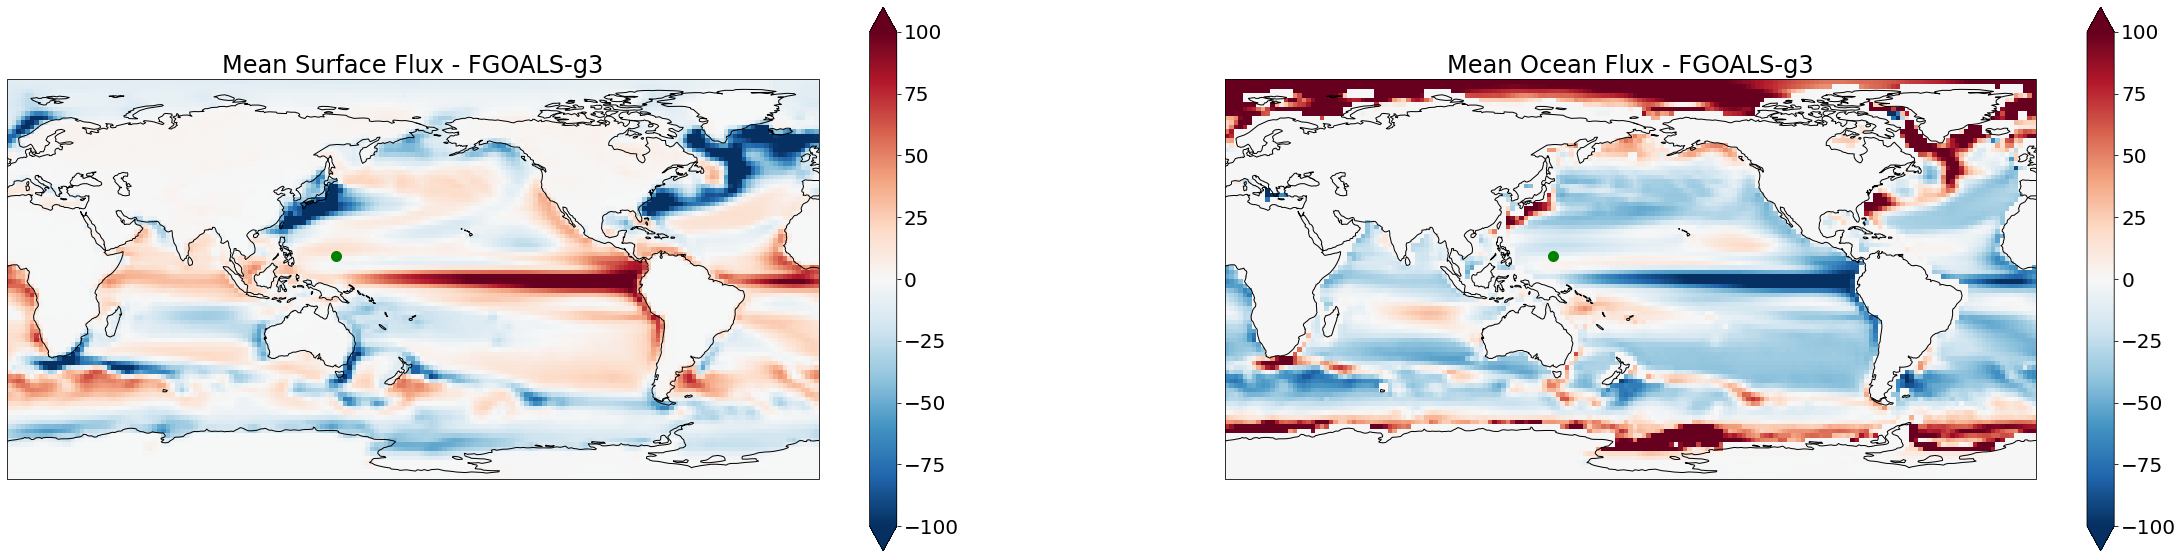

In [109]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 145
lat = 10

Qs_FGOALS = dataarray_Qs_cont.sel(name='FGOALS-g3').mean('time')

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_FGOALS.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux - FGOALS-g3')

Qo_FGOALS = dataarray_Qo_cont.sel(name='FGOALS-g3').mean('time')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_FGOALS.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux - FGOALS-g3')

In [76]:
warmpool_Qo=lagregress(dataarray_Qo_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name='FGOALS-g3'), 
                       dataarray_SST_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name='FGOALS-g3'),
                       lagint = 12*5)

In [77]:
warmpool_Qs=lagregress(dataarray_Qs_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name='FGOALS-g3'), 
                       dataarray_SST_cont.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name='FGOALS-g3'),
                       lagint = 12*5)

In [78]:
mean_hml = mlotst.sel(lat=10,method='nearest').sel(lon=145,method='nearest').sel(name='FGOALS-g3').mean('time')
mean_hml

<xarray.DataArray ()>
array(53.67645925)
Coordinates:
    latitude   float32 11.0
    longitude  float32 -215.0
    lat        int64 11
    lon        int64 145
    name       <U9 'FGOALS-g3'

In [79]:
params = {}
params['lambda_a'] = 20
params['lambda_o'] = 20
params['sigma_a'] = 1
params['sigma_o'] = 1
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a month - seconds
mlotst_equator = 53.6764925 # Mixed layer depth at equator - m

atmos_warmpool, ocean_warmpool = analytical(params, lagint)

Text(0.5, 0.98, '(145,10) in FGOALS-g3')

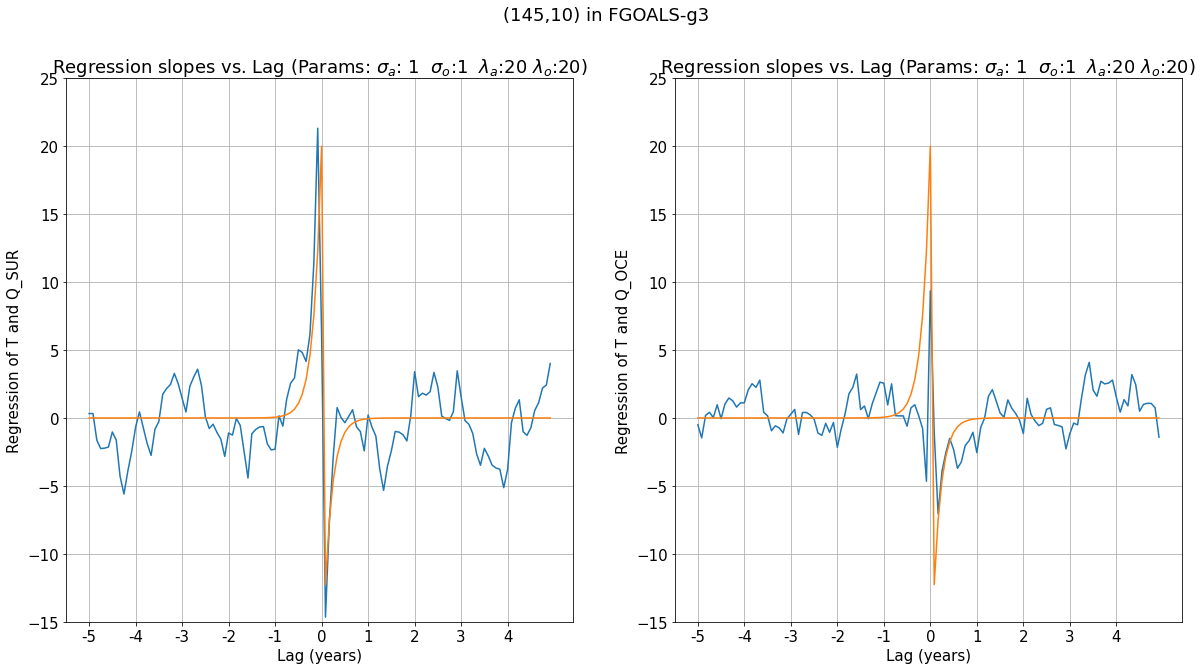

In [80]:
# Full 5 years

plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

# Atmosphere
ax.plot(warmpool_Qs[1], warmpool_Qs[0])
ax.plot(warmpool_Qs[1], atmos_warmpool)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-15,25)
ax.set_xlabel('Lag (years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(warmpool_Qo[1], warmpool_Qo[0])
ax2.plot(warmpool_Qo[1], ocean_warmpool)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_xlabel('Lag (years)')
ax2.set_ylim(-15,25)
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(145,10) in FGOALS-g3')

# (158,38) - CanESM5

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

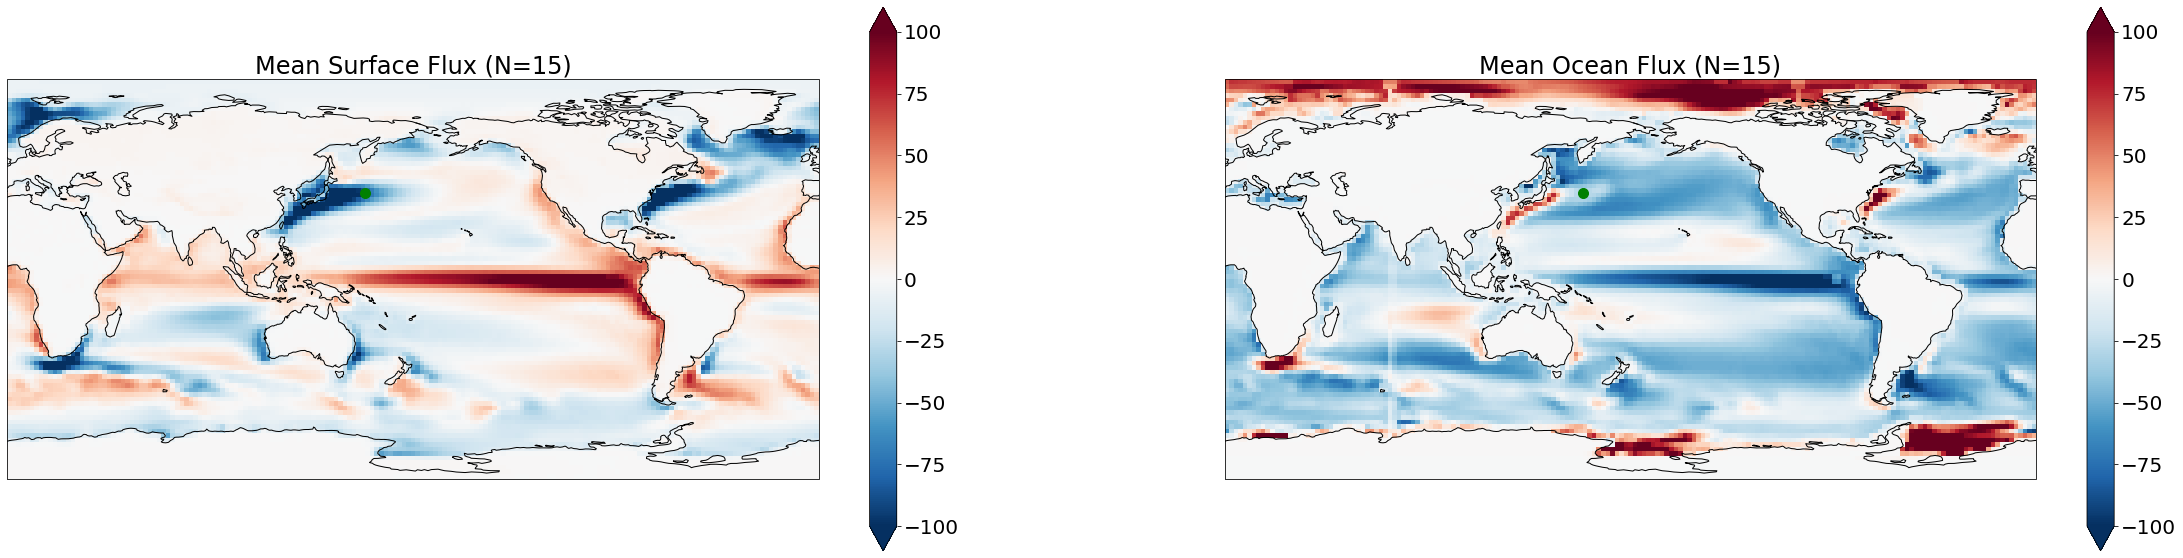

In [6]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 158
lat = 38

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [7]:
atmet_list = []
oceet_list = []
for model in dataarray_SST_cont['name']:
    atmet_list.append(lagregress(dataarray_Qs_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name=model),
                              lagint = 12*5))
    oceet_list.append(lagregress(dataarray_Qo_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name=model),
                         lagint = 12*5))

In [8]:
atmetlist = []
for i in range(15):
    atmetlist.append(atmet_list[i][0])
atmet = np.mean(atmetlist, axis=0)

oceetlist = []
for i in range(15):
    oceetlist.append(oceet_list[i][0])
oceet = np.mean(oceetlist, axis=0)

In [53]:
mlotst_equator = mlotst.sel(lat=38,method='nearest').sel(lon=158,method='nearest').mean('time').mean('name')
mlotst_equator.values

array(84.72027365)

In [54]:
params = {}
params['lambda_a'] = 9
params['lambda_o'] = 9
params['sigma_a'] = 1.3
params['sigma_o'] = 2
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = mlotst_equator.values # Mixed layer depth at equator - m

extratrop_analytic_atmos, extratrop_analytic_ocean = analytical(params, lagint)

Text(0.5, 0.98, '(158,38) - (N=15)')

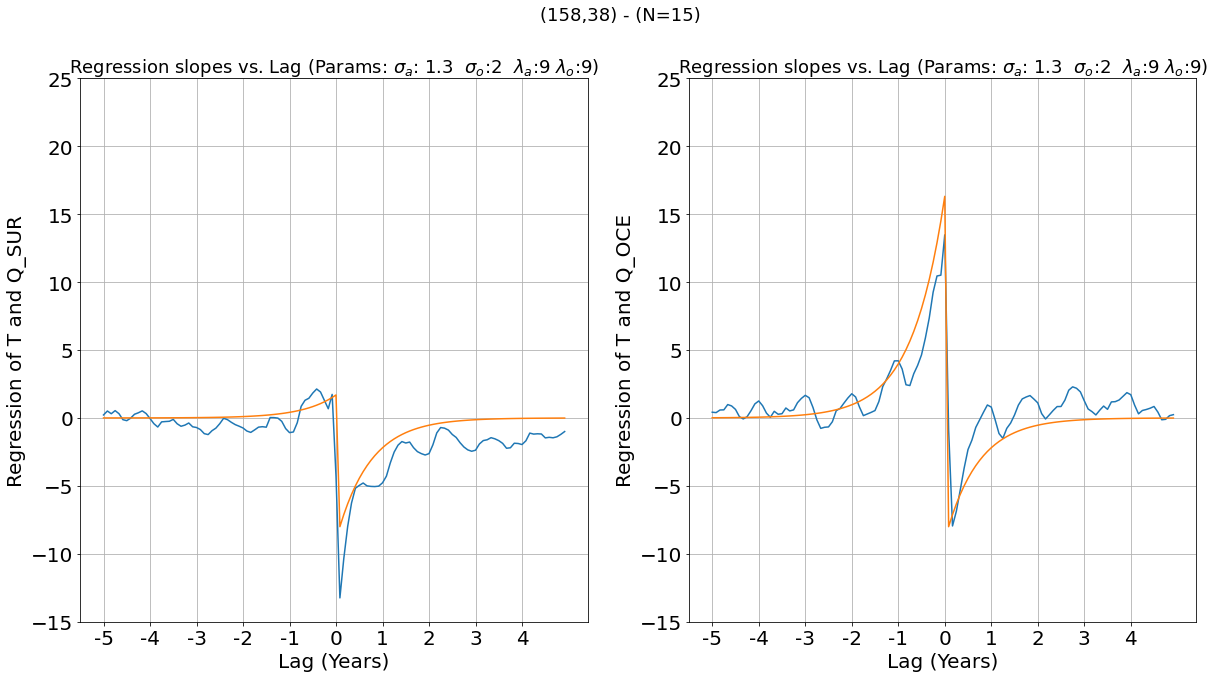

In [72]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax.plot(atmet_list[0][1], atmet)
ax.plot(atmet_list[0][1], extratrop_analytic_atmos)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-15,25)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(oceet_list[0][1], oceet)
ax2.plot(oceet_list[0][1], extratrop_analytic_ocean)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_ylim(-15,25)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(158,38) - (N=15)')

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

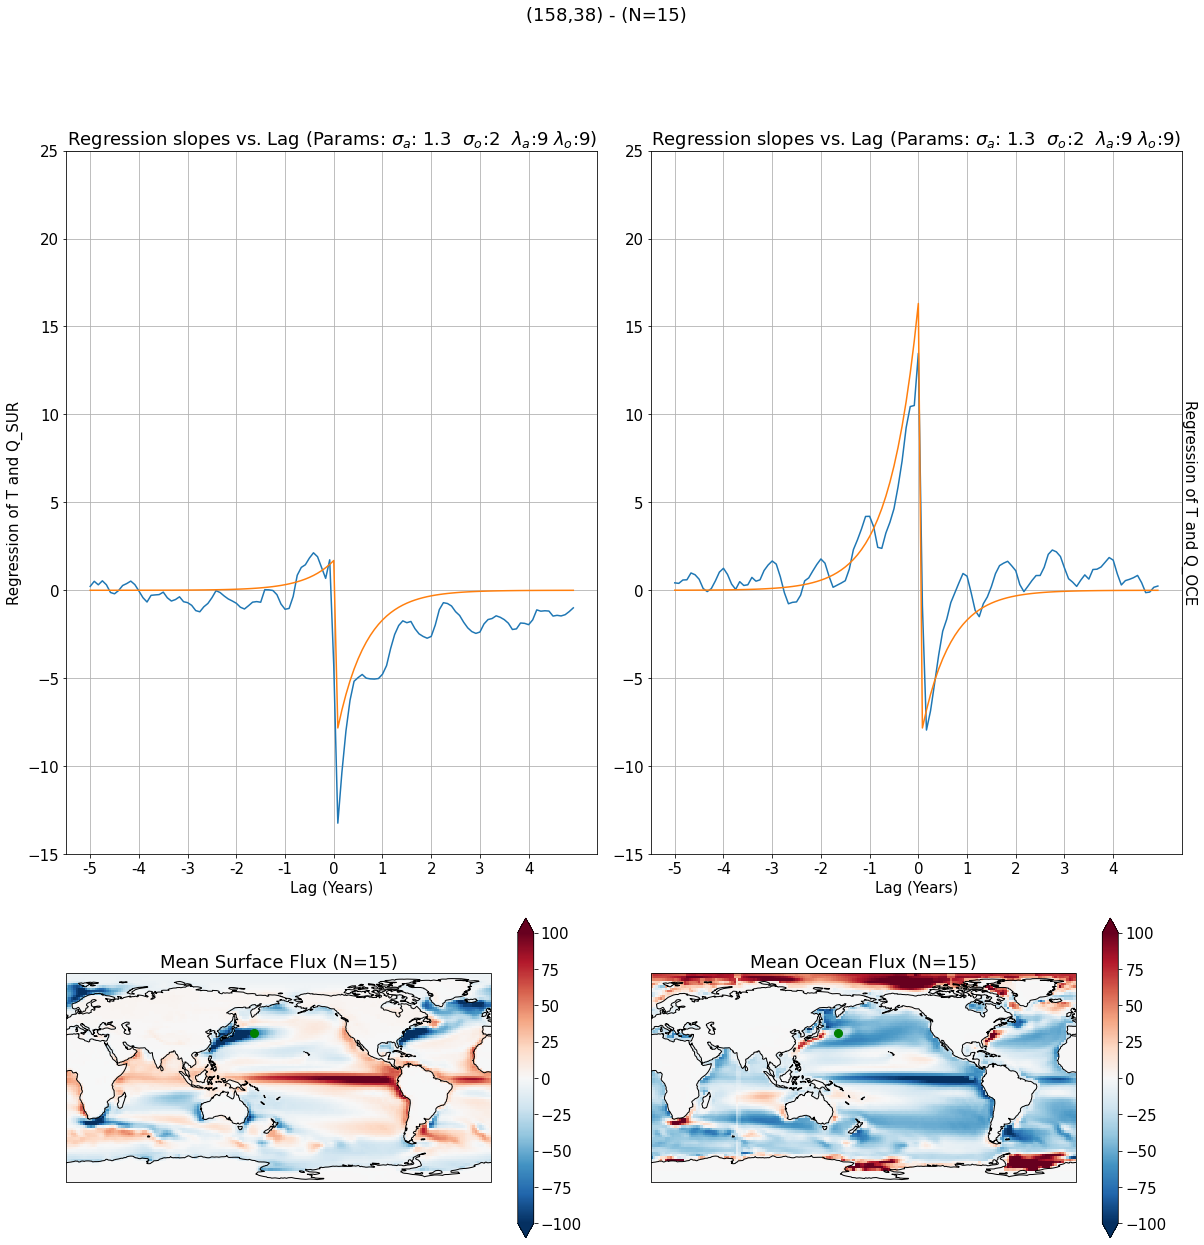

In [60]:
#fig, (ax,ax2) = plt.subplots(2,2, gridspec_kw={'height_ratios':[3,1]})

fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax1 = fig.add_subplot(gs[0:2,0])
ax1.plot(atmet_list[0][1], atmet)
ax1.plot(atmet_list[0][1], extratrop_analytic_atmos)
ax1.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax1.set_ylim(-15,25)
ax1.set_xlabel('Lag (Years)')
ax1.set_ylabel('Regression of T and Q_SUR')
ax1.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax1.grid()

# Ocean
ax2 = fig.add_subplot(gs[:2,1])
ax2.plot(oceet_list[0][1], oceet)
ax2.plot(oceet_list[0][1], extratrop_analytic_ocean)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_ylim(-15,25)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE', rotation=-90, labelpad=15)
ax2.yaxis.set_label_position("right")
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(158,38) - (N=15)')

lon = 158
lat = 38

ax3 = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax3, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax3.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=8, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax4 = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax4, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax4.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=8, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

Text(0.5, 1.0, 'Mean Ocean Flux - CanESM5')

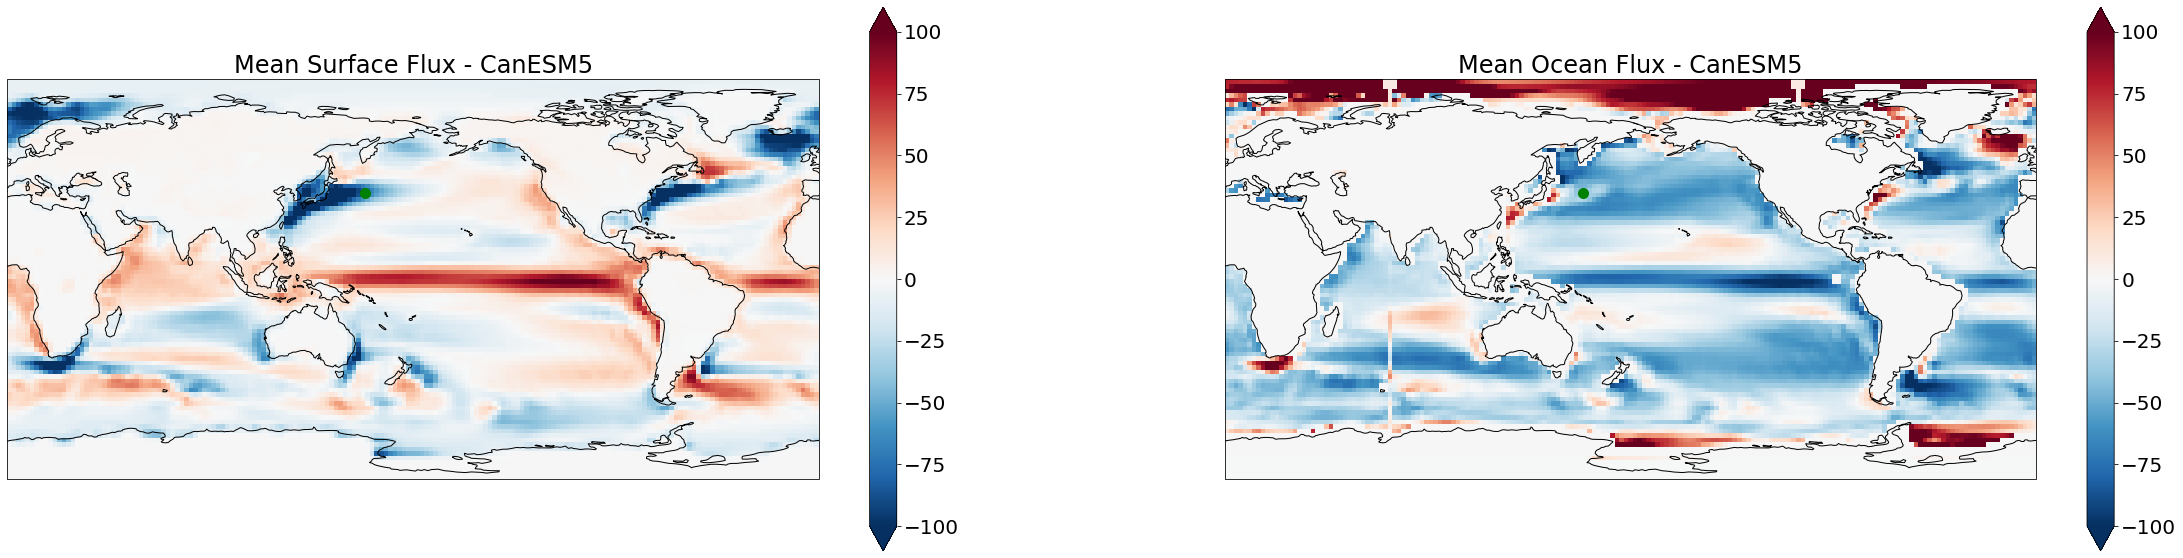

In [108]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 158
lat = 38

Qs_CanESM5 = dataarray_Qs_cont.sel(name='CanESM5').mean('time')

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_CanESM5.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux - CanESM5')

Qo_CanESM5 = dataarray_Qo_cont.sel(name='CanESM5').mean('time')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_CanESM5.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux - CanESM5')

In [45]:
extratrop_Qo=lagregress(dataarray_Qo_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name='CanESM5'), 
                        dataarray_SST_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name='CanESM5'),
                        lagint = 12*5)

In [46]:
extratrop_Qs=lagregress(dataarray_Qs_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name='CanESM5'), 
                        dataarray_SST_cont.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name='CanESM5'),
                        lagint = 12*5)

In [38]:
mean_hml = mlotst.sel(lat=38,method='nearest').sel(lon=158,method='nearest').sel(name='CanESM5').mean('time')
mean_hml

<xarray.DataArray ()>
array(100.39995001)
Coordinates:
    latitude   float32 39.0
    longitude  float32 -201.0
    lat        int64 39
    lon        int64 159
    name       <U7 'CanESM5'

In [42]:
mean_hml.values

array(100.39995001)

In [43]:
params = {}
params['lambda_a'] = 9
params['lambda_o'] = 9
params['sigma_a'] = 1.3
params['sigma_o'] = 2
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = mean_hml.values # Mixed layer depth at equator - m

extratrop_analytic_atmos, extratrop_analytic_ocean = analytical(params, lagint)

Text(0.5, 0.98, '(158,38) in CanESM5')

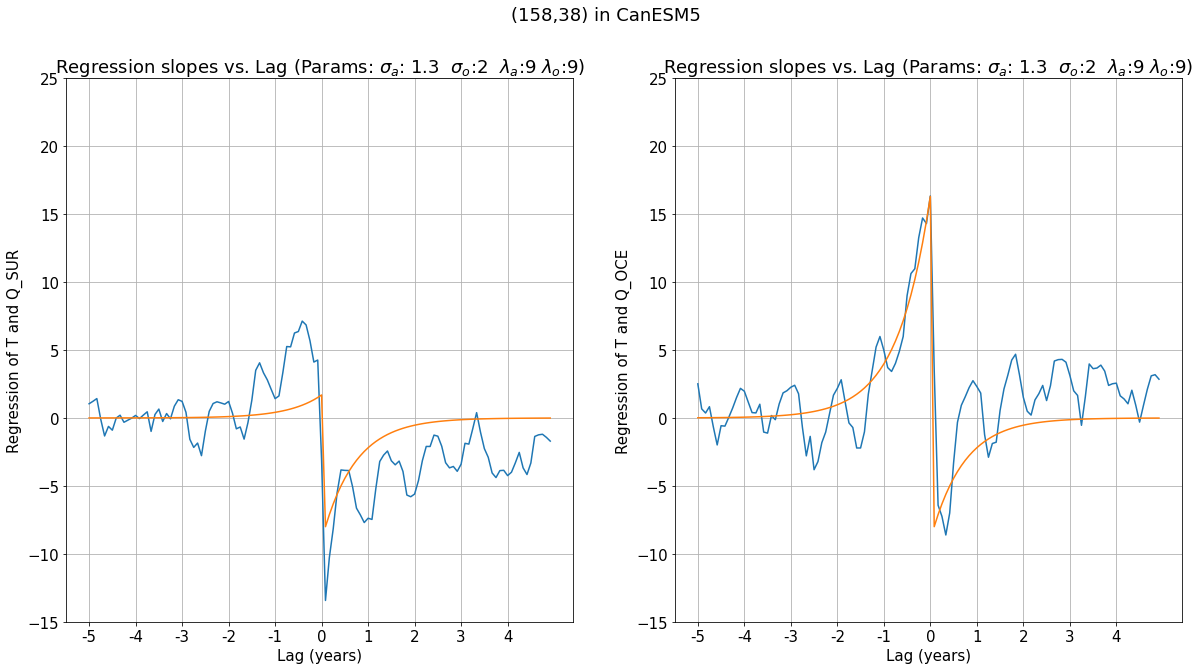

In [47]:
# Full 5 years

plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

# Atmosphere
ax.plot(extratrop_Qs[1], extratrop_Qs[0])
ax.plot(extratrop_Qs[1], extratrop_analytic_atmos)
ax.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax.set_ylim(-15,25)
ax.set_xlabel('Lag (years)')
ax.set_ylabel('Regression of T and Q_SUR')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(extratrop_Qo[1], extratrop_Qo[0])
ax2.plot(extratrop_Qo[1], extratrop_analytic_ocean)
ax2.set_xticks(np.arange(-12*5,12*5,12), np.arange(-5,5,1))
ax2.set_xlabel('Lag (years)')
ax2.set_ylim(-15,25)
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax2.grid()

plt.suptitle('(158,38) in CanESM5')

# Warm Pool - Point 2 (158,-15)

In [101]:
def plot(atm_lag, oce_lag, atmos_a, ocean_a, laglist, lagint, params, Qo, Qs, lon, lat):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(3, 2)
    gs.update(wspace=0.1)

    font = {'size'   : 15,
            'weight' : 'normal'}

    matplotlib.rc('font', **font)

    # Atmosphere
    ax1 = fig.add_subplot(gs[0:2,0])
    ax1.plot(laglist, atm_lag)
    ax1.plot(laglist, atmos_a)
    ax1.set_xticks(np.arange(-12*lagint,12*lagint,12), np.arange(-lagint,lagint,1))
    #ax1.set_ylim(-15,25)
    ax1.set_xlabel('Lag (Years)')
    ax1.set_ylabel('Regression of T and Q_SUR')
    ax1.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
    ax1.grid()

    # Ocean
    ax2 = fig.add_subplot(gs[:2,1])
    ax2.plot(laglist, oce_lag)
    ax2.plot(laglist, ocean_a)
    ax2.set_xticks(np.arange(-12*lagint,12*lagint,12), np.arange(-lagint,lagint,1))
    #ax2.set_ylim(-15,25)
    ax2.set_xlabel('Lag (Years)')
    ax2.set_ylabel('Regression of T and Q_OCE', rotation=-90, labelpad=15)
    ax2.yaxis.set_label_position("right")    
    ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
    ax2.grid()

    plt.suptitle('(' + str(lon) + ',' + str(lat) + ') - (N=15)', y=0.94)

    lon = lon
    lat = lat

    Qo_mean = Qo.mean('time').mean('name')
    Qs_mean = Qs.mean('time').mean('name')

    ax3 = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=180))
    Qs_mean.plot(ax=ax3, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
    ax3.coastlines(color='black', linewidth=1)
    plt.plot(lon,lat, marker='o', color='g', markersize=8, transform=ccrs.PlateCarree())
    plt.title('Mean Surface Flux (N=15)')

    ax4 = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree(central_longitude=180))
    Qo_mean.plot(ax=ax4, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
    ax4.coastlines(color='black', linewidth=1)
    plt.plot(lon,lat, marker='o', color='g', markersize=8, transform=ccrs.PlateCarree())
    plt.title('Mean Ocean Flux (N=15)')

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

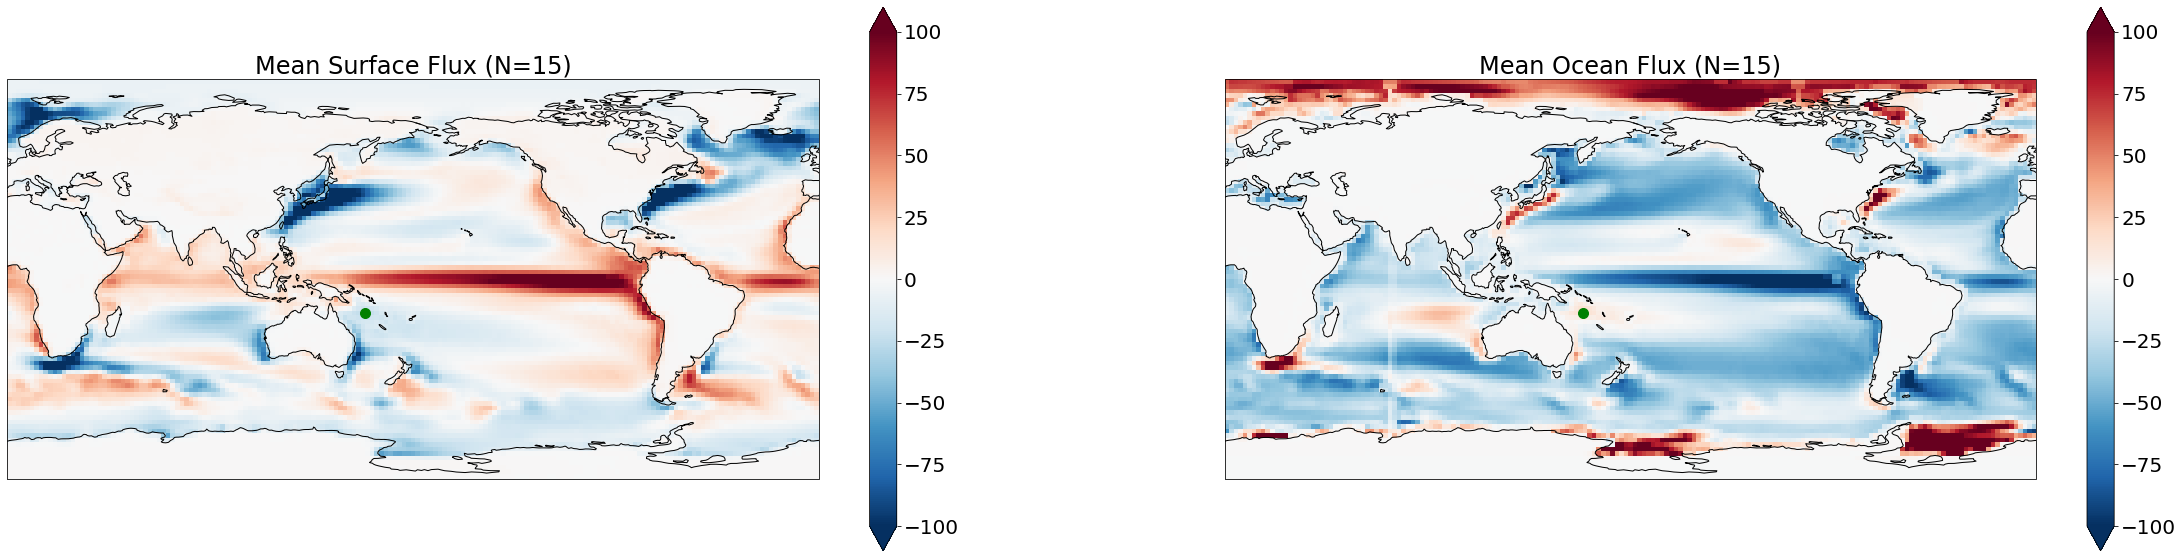

In [8]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 158
lat = -15

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [10]:
atmwp2_list = []
ocewp2_list = []
for model in dataarray_SST_cont['name']:
    atmwp2_list.append(lagregress(dataarray_Qs_cont.sel(lat=-15,method='nearest').sel(lon=158,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=-15,method='nearest').sel(lon=158,method='nearest').sel(name=model),
                              lagint = 12*5))
    ocewp2_list.append(lagregress(dataarray_Qo_cont.sel(lat=-15,method='nearest').sel(lon=158,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=-15,method='nearest').sel(lon=158,method='nearest').sel(name=model),
                         lagint = 12*5))

In [11]:
atmwp2list = []
for i in range(15):
    atmwp2list.append(atmwp2_list[i][0])
atmwp2 = np.mean(atmwp2list, axis=0)

ocewp2list = []
for i in range(15):
    ocewp2list.append(ocewp2_list[i][0])
ocewp2 = np.mean(ocewp2list, axis=0)

In [12]:
mlotst_wp2 = mlotst.sel(lat=-15,method='nearest').sel(lon=158,method='nearest').mean('time').mean('name')
mlotst_wp2.values

array(33.30860104)

In [93]:
params = {}
params['lambda_a'] = 15
params['lambda_o'] = 15
params['sigma_a'] = 2
params['sigma_o'] = 1.3
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = mlotst_wp2.values # Mixed layer depth at equator - m
wp2_analytic_atmos, wp2_analytic_ocean = analytical(params, lagint)

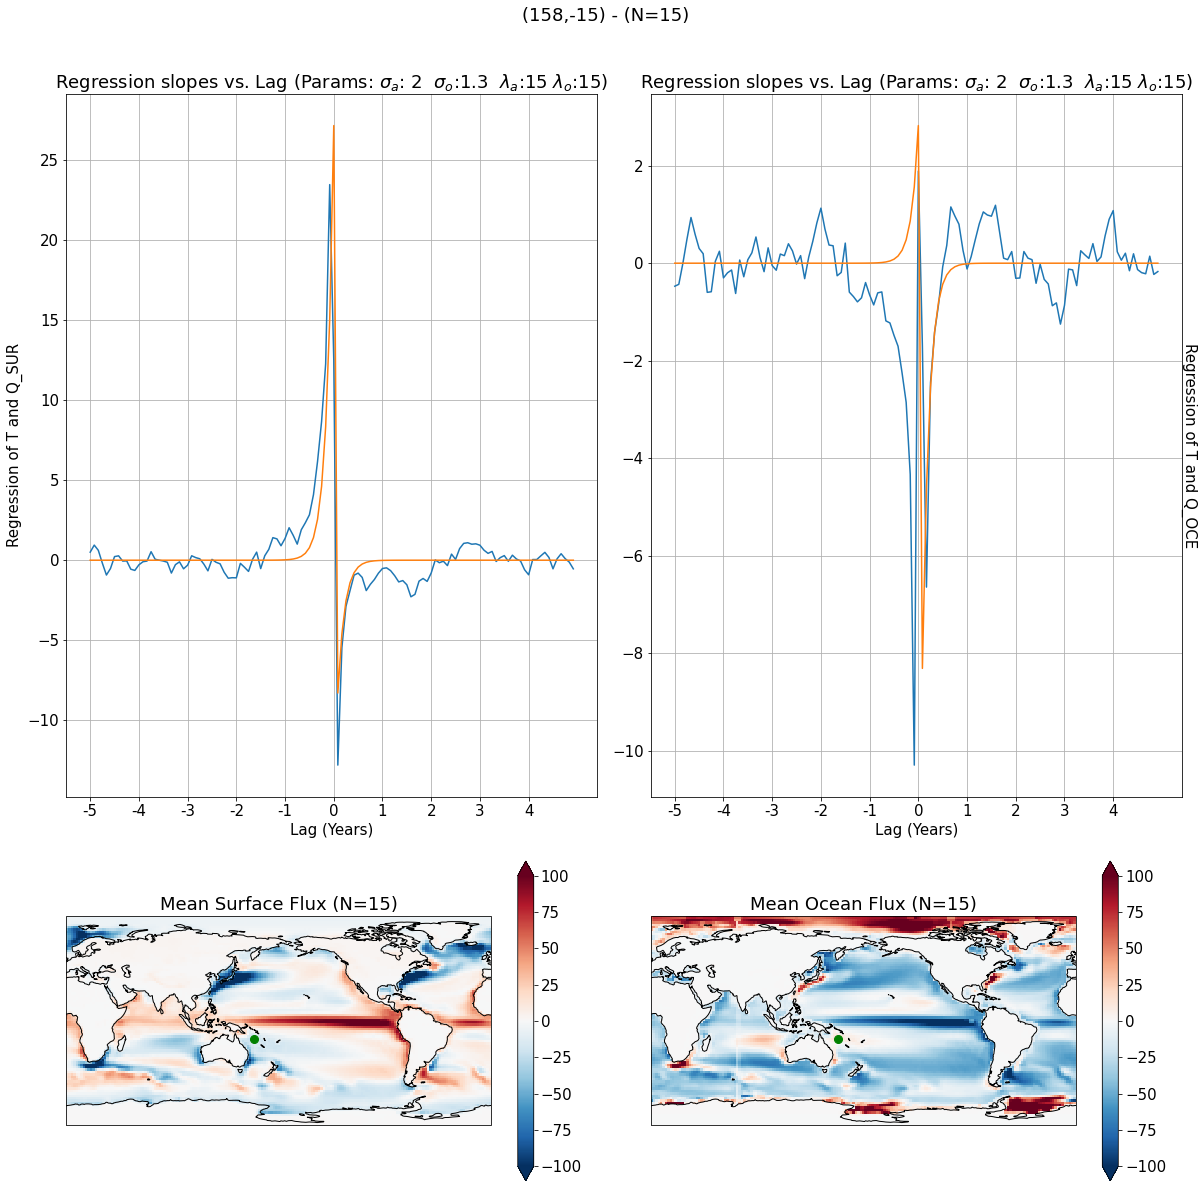

In [102]:
plot(atmwp2, ocewp2, wp2_analytic_atmos, wp2_analytic_ocean, atmwp2_list[0][1], 5, params,
    dataarray_Qo_cont, dataarray_Qs_cont, 158,-15)

# Warm Pool - Point 3 (190,-15)

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

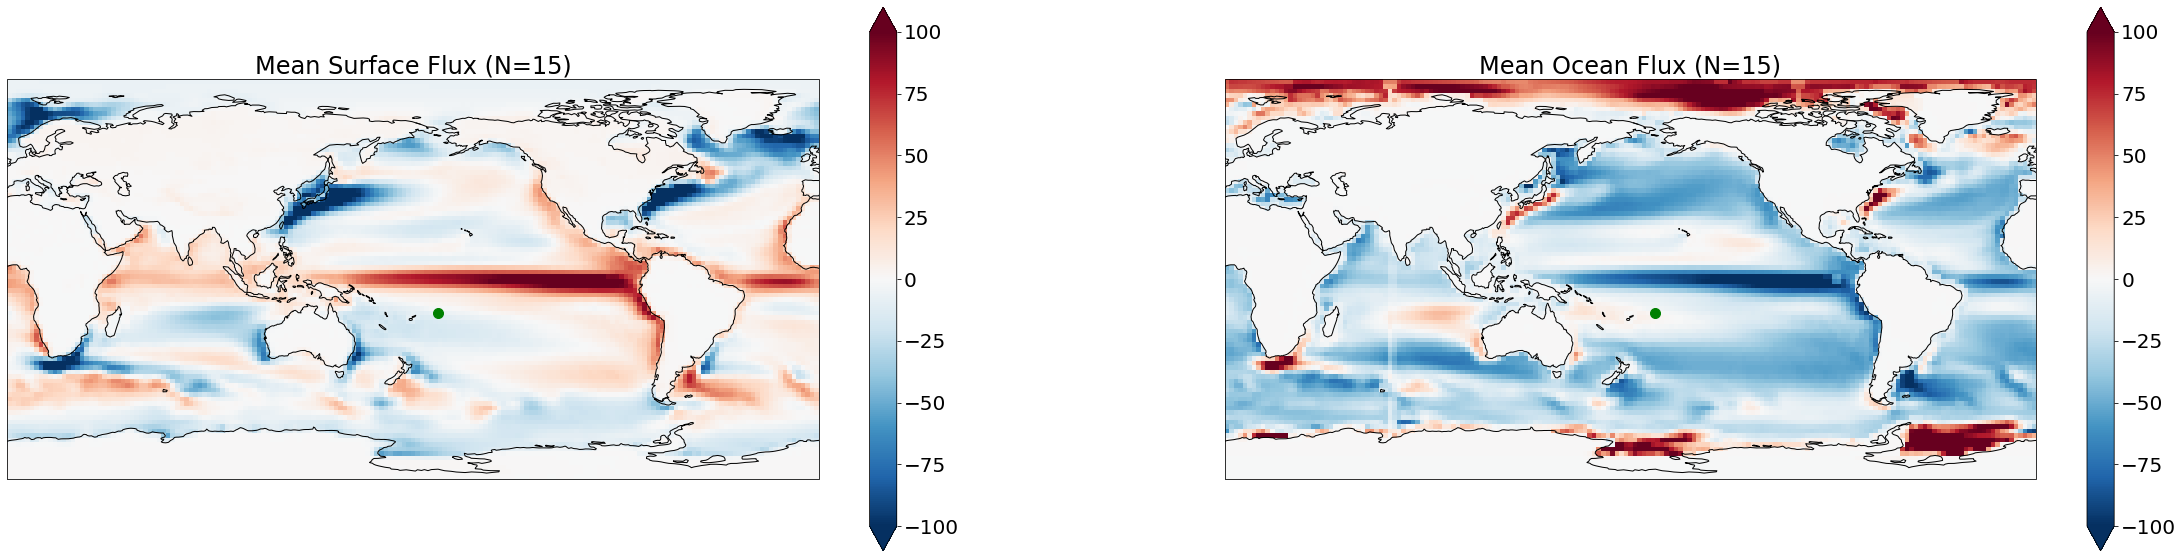

In [30]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 190
lat = -15

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [31]:
atmwp3_list = []
ocewp3_list = []
for model in dataarray_SST_cont['name']:
    atmwp3_list.append(lagregress(dataarray_Qs_cont.sel(lat=-15,method='nearest').sel(lon=190,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=-15,method='nearest').sel(lon=190,method='nearest').sel(name=model),
                              lagint = 12*5))
    ocewp3_list.append(lagregress(dataarray_Qo_cont.sel(lat=-15,method='nearest').sel(lon=190,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=-15,method='nearest').sel(lon=190,method='nearest').sel(name=model),
                         lagint = 12*5))

In [32]:
atmwp3list = []
for i in range(15):
    atmwp3list.append(atmwp3_list[i][0])
atmwp3 = np.mean(atmwp3list, axis=0)

ocewp3list = []
for i in range(15):
    ocewp3list.append(ocewp3_list[i][0])
ocewp3 = np.mean(ocewp3list, axis=0)

In [33]:
mlotst_wp3 = mlotst.sel(lat=-15,method='nearest').sel(lon=190,method='nearest').mean('time').mean('name')
mlotst_wp3.values

array(30.38284546)

In [107]:
params = {}
params['lambda_a'] = 15
params['lambda_o'] = 15
params['sigma_a'] = 2
params['sigma_o'] = 1.3
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = mlotst_wp3.values # Mixed layer depth at equator - m
wp3_analytic_atmos, wp3_analytic_ocean = analytical(params, lagint)

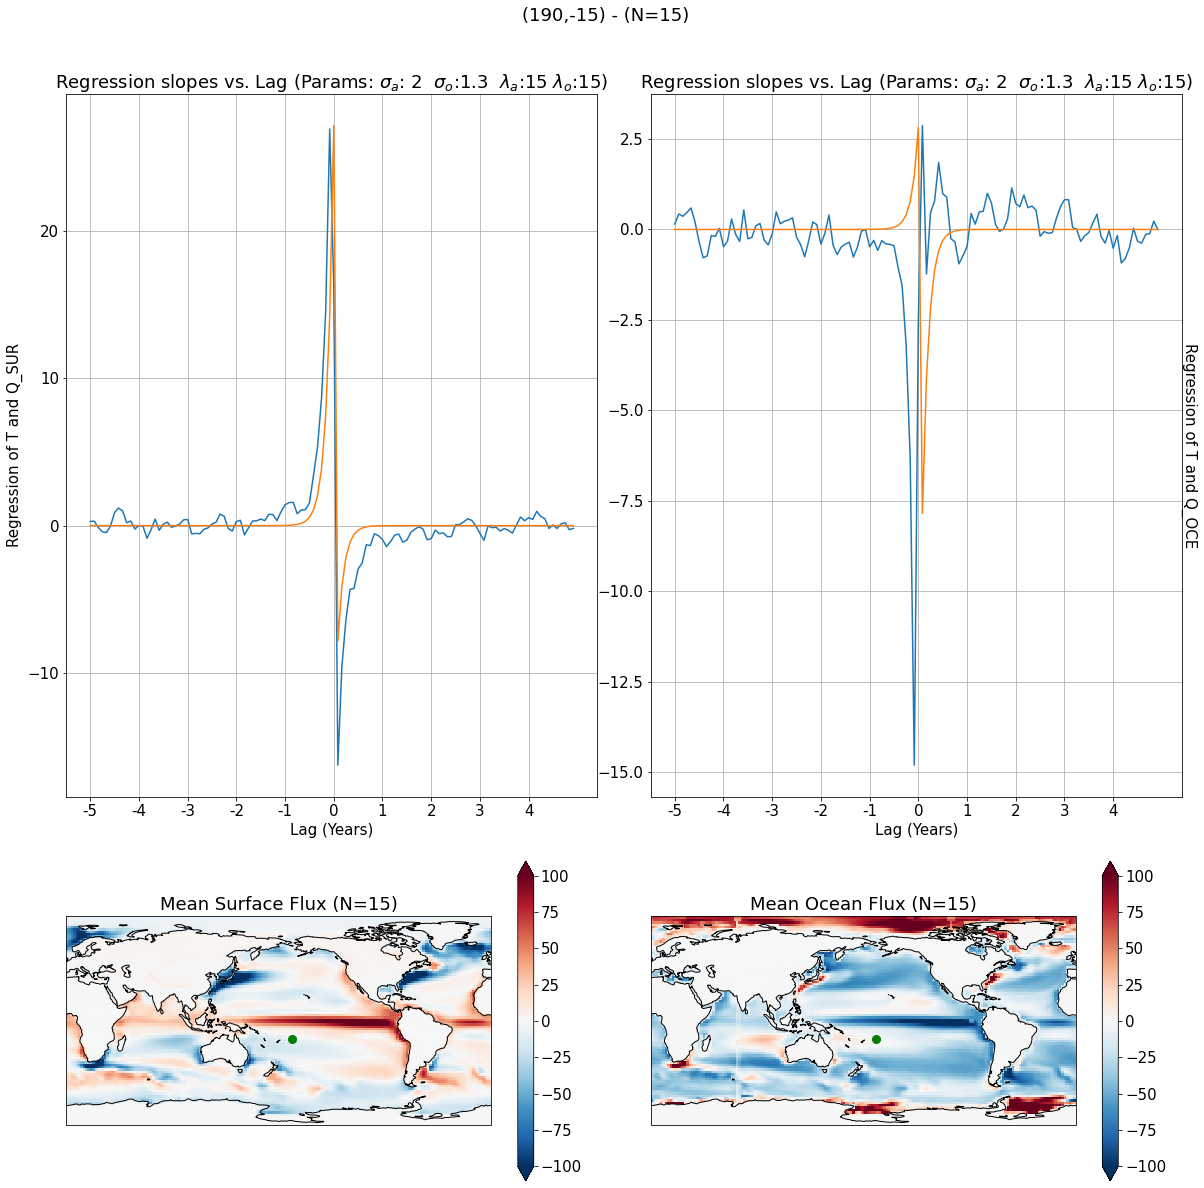

In [108]:
plot(atmwp3, ocewp3, wp3_analytic_atmos, wp3_analytic_ocean, atmwp3_list[0][1], 5, params,
    dataarray_Qo_cont, dataarray_Qs_cont, 190,-15)

# Warm Pool - Point 4 (160,0)

Text(0.5, 1.0, 'Mean Ocean Flux (N=15)')

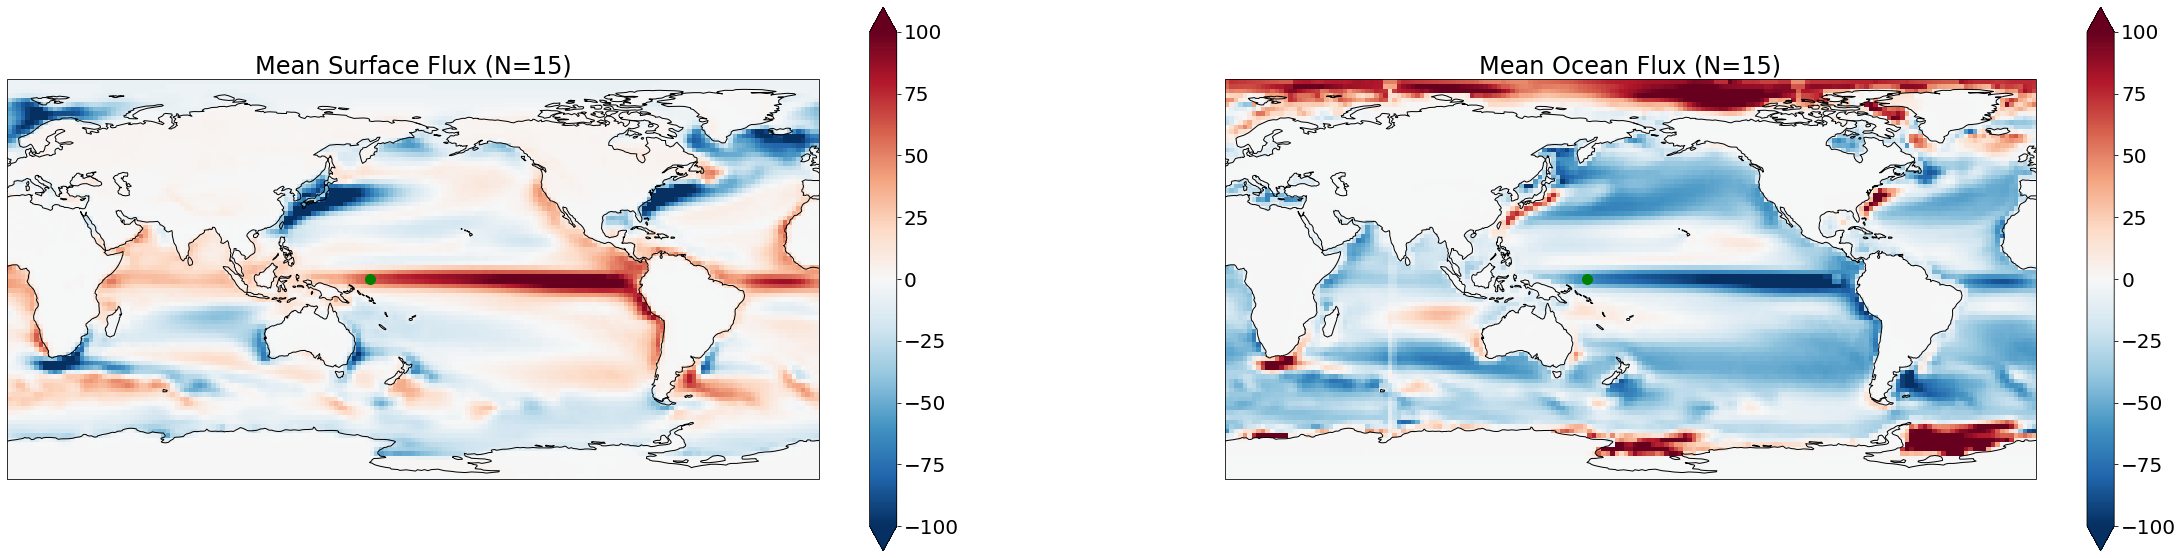

In [39]:
fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

lon = 160
lat = 0

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
Qs_mean.plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax1.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Surface Flux (N=15)')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))
Qo_mean.plot(ax=ax2, transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap='RdBu_r')
ax2.coastlines(color='black', linewidth=1)
plt.plot(lon,lat, marker='o', color='g', markersize=10, transform=ccrs.PlateCarree())
plt.title('Mean Ocean Flux (N=15)')

In [40]:
atmwp4_list = []
ocewp4_list = []
for model in dataarray_SST_cont['name']:
    atmwp4_list.append(lagregress(dataarray_Qs_cont.sel(lat=0,method='nearest').sel(lon=160,method='nearest').sel(name=model), 
                              dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=160,method='nearest').sel(name=model),
                              lagint = 12*5))
    ocewp4_list.append(lagregress(dataarray_Qo_cont.sel(lat=0,method='nearest').sel(lon=160,method='nearest').sel(name=model), 
                         dataarray_SST_cont.sel(lat=0,method='nearest').sel(lon=160,method='nearest').sel(name=model),
                         lagint = 12*5))

In [41]:
atmwp4list = []
for i in range(15):
    atmwp4list.append(atmwp4_list[i][0])
atmwp4 = np.mean(atmwp4list, axis=0)

ocewp4list = []
for i in range(15):
    ocewp4list.append(ocewp4_list[i][0])
ocewp4 = np.mean(ocewp4list, axis=0)

In [42]:
mlotst_wp4 = mlotst.sel(lat=0,method='nearest').sel(lon=160,method='nearest').mean('time').mean('name')
mlotst_wp4.values

array(24.75634364)

In [109]:
params = {}
params['lambda_a'] = 12
params['lambda_o'] = 1
params['sigma_a'] = 0.01
params['sigma_o'] = 10
years = 125
lagint = 12*5

density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 30*24*60*60 #Time in a week - seconds
mlotst_equator = mlotst_wp4.values # Mixed layer depth at equator - m
wp4_analytic_atmos, wp4_analytic_ocean = analytical(params, lagint)

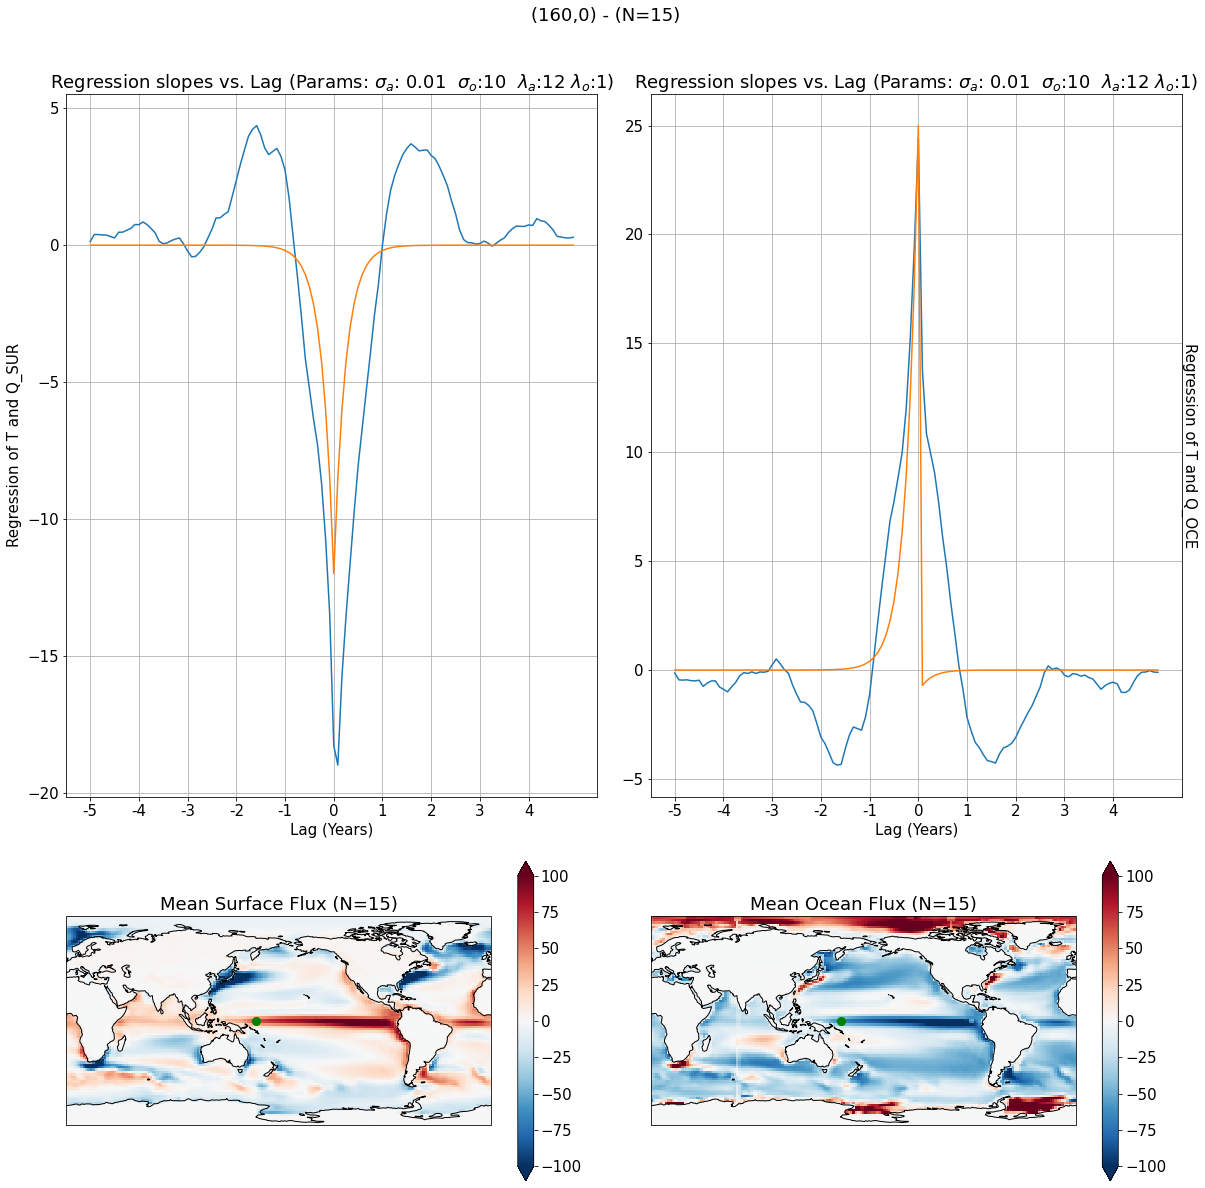

In [110]:
plot(atmwp4, ocewp4, wp4_analytic_atmos, wp4_analytic_ocean, atmwp4_list[0][1], 5, params,
    dataarray_Qo_cont, dataarray_Qs_cont, 160,0)